In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing **Libraries**

In [2]:
import pandas as pd
import re    # for regular expressions 
import nltk  # for text manipulation 
import string # for text manipulation 
import warnings 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore") #ignore warnings

# Read the Data 

In [3]:
df = pd.read_csv("/content/drive/MyDrive/training.1600000.processed.noemoticon.csv",encoding='latin-1',header=None) 

In [4]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [5]:
df.shape

(1600000, 6)

# Add colomn names

In [6]:
df_columns_name = ["target", "ids", "date", "flag", "user", "TweetText"]
df.columns = df_columns_name
df.head()

,target,ids,date,flag,user,TweetText
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


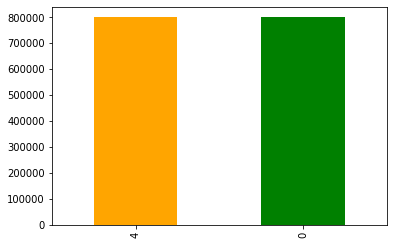

In [7]:
df['target'].value_counts().plot(kind='bar',color=["orange","green"])

### Count the target

4    800000
0    800000
Name: target, dtype: int64


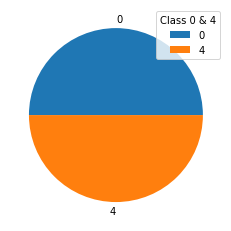

In [8]:
cls_cnt = df['target'].value_counts()
print(cls_cnt)
plt.pie([cls_cnt[0],cls_cnt[4]],labels=[0,4])
plt.legend(title = "Class 0 & 4",loc='best')

## **TRY TO FIND REALATION WITH LENGHTH**

In [9]:
df_unhapy = df.loc[df['target']==0]
df_hapy = df.loc[df['target']==4]

- Average tweet length


In [10]:
print(df['TweetText'].str.len().mean())

74.09011125


- Average Word length of the tweet for seperate real and fake set

In [11]:
unhapy_wordlen = df_unhapy['TweetText'].str.split().apply(lambda x: len(x))
hapy_wordlen = df_hapy['TweetText'].str.split().apply(lambda x: len(x))
print(f'The Mean of Fake class = {unhapy_wordlen.mean()}')
print(f'The Mean of Real class = {hapy_wordlen.mean()}')

The Mean of Fake class = 13.58198375
The Mean of Real class = 12.7703175


Mean Word count of both the classes

In [12]:
import seaborn as sns

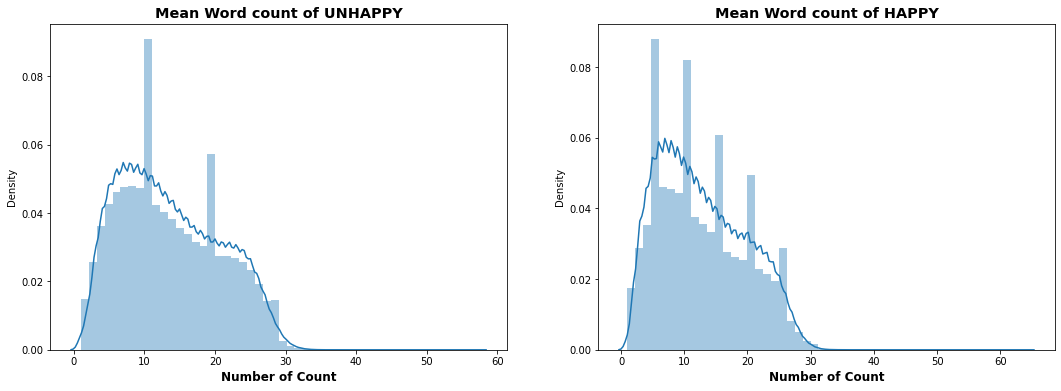

In [13]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title("Mean Word count of UNHAPPY",weight='bold',fontsize='x-large')
sns.distplot(unhapy_wordlen.map(lambda x: np.mean(x)))
plt.xlabel('Number of Count',weight='bold',fontsize='large')
plt.subplot(122)
plt.title("Mean Word count of HAPPY",weight='bold',fontsize='x-large')
sns.distplot(hapy_wordlen.map(lambda x: np.mean(x)))
plt.xlabel('Number of Count',weight='bold',fontsize='large')
plt.show()

drop all the colomns except target variable and tweets text

In [14]:
# Let's keep only target variable and tweets text
data = df
df.drop(['ids','date','flag','user'],axis = 1,inplace = True)

In [15]:
df.head()

,target,TweetText
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [16]:
df_positive_tweet = df[df.target==4].iloc[:18000,:]
df_negative_tweet = df[df.target==0].iloc[:2000,:]
print(df_positive_tweet.shape)
print(df_negative_tweet.shape)

(18000, 2)
(2000, 2)


In [17]:
df_tweetdata = pd.concat([df_positive_tweet,df_negative_tweet],axis = 0)
print(df_tweetdata.shape)
df_tweetdata.head()

(20000, 2)


,target,TweetText
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
800003,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
800004,4,@LovesBrooklyn2 he has that effect on everyone


# **Data Cleaning**

In [18]:
#Check for missing values
df_tweetdata.isnull().sum()

# 100*df_tweetdata.isna().sum()/len(df_tweetdata)

target       0
TweetText    0
dtype: int64

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
stopwords=nltk.corpus.stopwords.words('english')

# **Clean Tweets**

In [21]:
def Stopwords_Removal(text):
    lst = " "
    clean_text=lst.join([word for word in text.split() if word not in stopwords])
    return clean_text

In [22]:
from nltk.stem.porter import PorterStemmer
def Tweets_cleanup(df_tweetdata):
    str_1 = ""
    str_2 = " "

    # Remove handle (@)
    df_tweetdata['clean_tweet'] = df_tweetdata['TweetText'].str.replace("@", str_1) 

    # Remove all Links (https...)
    df_tweetdata['clean_tweet'] = df_tweetdata['clean_tweet'].str.replace(r"http\S+", str_1) 

    # Remove Punctuations & Special characters
    df_tweetdata['clean_tweet'] = df_tweetdata['clean_tweet'].str.replace("[^a-zA-Z]", str_2) 

    # Remove the Stop words
    df_tweetdata['clean_tweet'] = df_tweetdata['clean_tweet'].apply(lambda text : Stopwords_Removal(text.lower()))

    # Split the text and tokenize it 
    df_tweetdata['clean_tweet'] = df_tweetdata['clean_tweet'].apply(lambda lm: lm.split())

    # Now apply Stemmer (Porter)
    stemmer = PorterStemmer()
    df_tweetdata['clean_tweet'] = df_tweetdata['clean_tweet'].apply(lambda lm: [stemmer.stem(i) for i in lm])

    # Stitch back words
    df_tweetdata['clean_tweet'] = df_tweetdata['clean_tweet'].apply(lambda lm: ' '.join([w for w in lm]))

    # Remove small words
    df_tweetdata['clean_tweet'] = df_tweetdata['clean_tweet'].apply(lambda lm: ' '.join([w for w in lm.split() if len(w)>3]))

In [23]:
Tweets_cleanup(df_tweetdata)

In [24]:
df_tweetdata.head()

,target,TweetText,clean_tweet
800000,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpet best
800001,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,meet besti tonight cant wait girl talk
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.",darealsunisakim thank twitter sunisa meet show area sweetheart
800003,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup",sick realli cheap hurt much real food friend make soup
800004,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyon


Spelling correction

it take more time to run, so we only put the code out here.

In [25]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7MB 23.9MB/s 


In [26]:
from spellchecker import SpellChecker
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:   
            corrected_text.append(word)
    return " ".join(corrected_text)
        
df_tweetdata['clean_tweet'] = df_tweetdata['clean_tweet'].apply(lambda text: correct_spellings(text))

# **Word clouds (EDA)**

In [27]:
# function to display word clous
from wordcloud import WordCloud,STOPWORDS

def Create_WordCloud_for_sentiment(targz):
    df_tmp1 = pd.DataFrame() 
    if (targz == -1) :
        df_tmp1 = df_tweetdata
    else:
        df_tmp1 = df_tweetdata[df_tweetdata.target==targz]
    wrdz = " ".join(df_tmp1.clean_tweet)
    wrdclud = WordCloud(stopwords=STOPWORDS,width=1500,
                      background_color='black',
                      height=1000).generate(wrdz)
    plt.figure(figsize=(10,10))
    plt.imshow(wrdclud)
    plt.axis('off')
    plt.show

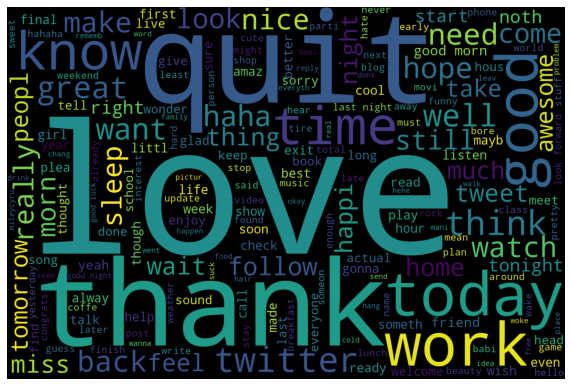

In [28]:
Create_WordCloud_for_sentiment(-1)

- Tweets of Positive sentiment (4)

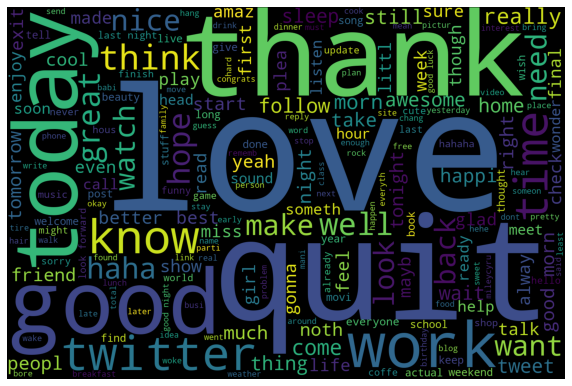

In [29]:
Create_WordCloud_for_sentiment(4) 

- Tweets of Negative sentiment (0)

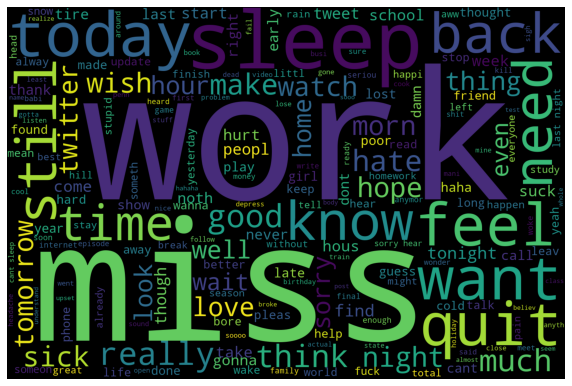

In [30]:
Create_WordCloud_for_sentiment(0) 

- Data balance

In [31]:
def createPieChartFor(t_df):
    cnt = 100*t_df.value_counts()
    cnt/=len(t_df)

    # Set the data for pie chart
    labls = t_df.value_counts().index.values
    szs =  cnt 
    
    # Set the Labels
    fig1, ax1 = plt.subplots()
    ax1.pie(szs, autopct='%1.2f%%', labels=labls,  shadow=True, startangle=90)
    ax1.axis('equal')  # Aspect ratio Equal shows that pie is drawn as a circle.
    plt.show()

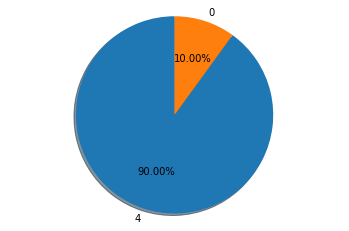

In [32]:
createPieChartFor(df_tweetdata.target)

# **Model Training**

## Make test-train split

In [33]:
df_tweetdata.head()

,target,TweetText,clean_tweet
800000,4,I LOVE @Health4UandPets u guys r the best!!,love health handset best
800001,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,meet best tonight cant wait girl talk
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.",darealsunisakim thank twitter sunita meet show area sweetheart
800003,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup",sick really cheap hurt much real food friend make soup
800004,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyone


In [34]:
df_tweet_train, df_tweet_test = train_test_split(df_tweetdata, test_size=0.3, random_state=42)

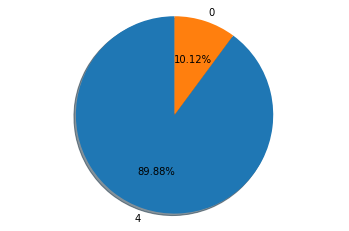

In [35]:
createPieChartFor(df_tweet_train.target)

In [36]:
lst_tweets_train =[]
lst_tweets_test =[]

for twet in df_tweet_train.clean_tweet:
    lst_tweets_train.append(twet)

for twet in df_tweet_test.clean_tweet:
    lst_tweets_test.append(twet)

In [37]:
lst_tweets_train[:10]

['today fell love amaz',
 'bransonpro',
 'ladybug love video laura',
 'charley cute sweet blue cheer tweeter',
 'yeti yeah photograph older stock list store design today',
 'derek she sweet except stretch browser watch twit',
 'active facebook account remove siphon good feel overall really',
 'twitter',
 'noth like come back work sick much catch nissan shave',
 'megan raise hand friend either twitter exit live']

# Term Frequency Inverse Document Frequency(TF-IDF)

- Bag of words model

In [38]:
vectorizer = TfidfVectorizer()
tweet_tfidf_train = vectorizer.fit_transform(lst_tweets_train)
tweet_tfidf_test = vectorizer.transform(lst_tweets_test)

In [39]:
# let's look at the dataframe
df_train_tfidf = pd.DataFrame(tweet_tfidf_train.toarray(), columns=vectorizer.get_feature_names())
print(df_train_tfidf.shape)
df_train_tfidf.head()

(14000, 14726)


,aaaaand,aagghhhhh,aalsmeer,aarondhoffman,aaronfilmmak,aaronrva,aaronstewart,aaronstrout,aarrggghh,aback,abarkerwoof,abba,abbey,abby,abdul,abeautifulmind,abegrub,aber,abhisheknagar,abhor,abigail,abigaillovesy,abisignorelli,abit,able,aboard,abolish,abound,aboust,about,aboutbirdi,abralynn,abroaaaaad,abroad,absence,absolut,absorb,absurd,abysmal,abyssum,...,zap,zappoman,zara,zealand,zealot,zeddessart,zeiss,zeke,zenaweist,zenite,zenobeach,zephyr,zergmoney,zero,zerogeewhiz,zfgokussj,zhuge,zikihekai,zillygrl,zinedistro,zing,zinger,zinziii,ziplock,zippo,znamosti,zoecello,zoekravitz,zom,zombi,zone,zoom,zrealizovat,zsasz,zukyleigh,zulu,zuraidah,zurich,zuzu,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


All Classifiers

In [40]:
classifier = [KNeighborsClassifier(n_neighbors = 5),
              DecisionTreeClassifier(),
              XGBClassifier(max_depth=6, 
              n_estimators=1000, nthread= 3),
              MultinomialNB(), 
              RandomForestClassifier(n_estimators=1000, random_state=42),
              LogisticRegression(),
              svm.SVC(),
              MLPClassifier(random_state=1, max_iter=200) ]
clss_name = []

fitting and calculating the accuracy of all classifiers

In [41]:
lbl_actual = df_tweet_test.target
tmp = 0
accu = []
for clf in classifier :
    mdl = clf.fit(tweet_tfidf_train,df_tweet_train.target)
    labl_predicted = mdl.predict(tweet_tfidf_test)
    cnt = (100*accuracy_score(labl_predicted, lbl_actual))
    cnt = round(cnt,2)
    accu.append(cnt)
    clss_name.append(clf.__class__.__name__)
    print (f'{clss_name[tmp]}  Accuracy Score : {cnt}')
    print (classification_report(labl_predicted, lbl_actual))
    tmp +=1

KNeighborsClassifier  Accuracy Score : 89.93
              precision    recall  f1-score   support

           0       0.04      0.34      0.07        65
           4       0.99      0.91      0.95      5935

    accuracy                           0.90      6000
   macro avg       0.51      0.62      0.51      6000
weighted avg       0.98      0.90      0.94      6000

DecisionTreeClassifier  Accuracy Score : 86.4
              precision    recall  f1-score   support

           0       0.23      0.27      0.25       499
           4       0.93      0.92      0.93      5501

    accuracy                           0.86      6000
   macro avg       0.58      0.59      0.59      6000
weighted avg       0.87      0.86      0.87      6000

XGBClassifier  Accuracy Score : 90.53
              precision    recall  f1-score   support

           0       0.18      0.54      0.27       199
           4       0.98      0.92      0.95      5801

    accuracy                           0.91      6000

Graph of all accuracy by with respected classifiers

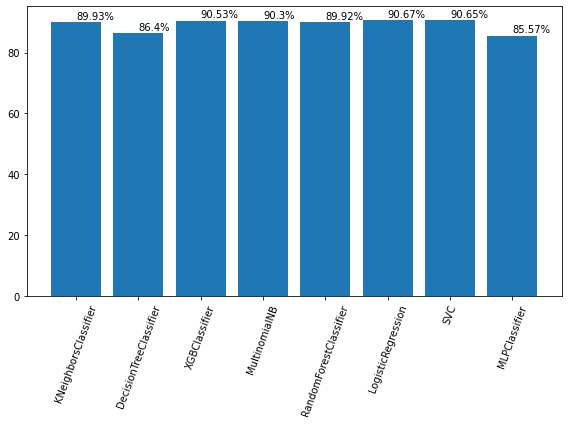

In [42]:
plt.figure(figsize=(8,6))
plt.bar(clss_name, accu)
plt.xticks(rotation=70)
for idx,val in enumerate(accu):
    plt.text(x=idx , y =val+1 , s=f"{val}%" , fontdict=dict(fontsize=10))
plt.tight_layout()
plt.show()